In [1]:
from util import vcd_parser, get_traces, plot_traces

from molemu import (InterParticleForce,
                    VelocityVerletIntegrator,
                    IdealSpringInteraction,
                    Cell)

from nmigen.back.pysim import Simulator, Tick, Settle

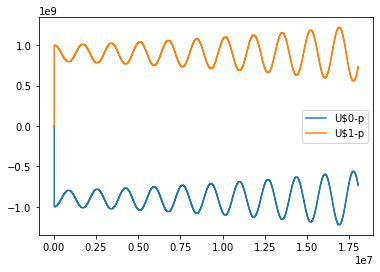

In [5]:
nsteps = 1800

i = Cell(num_bits=32, ghost_layer=16)

def testbench():

    yield i.rst.eq(1)
    yield Tick()
    yield i.p0[0].eq(-1000000000)
    yield i.v0[0].eq(0)
    yield i.p0[1].eq(1000000000)
    yield i.v0[1].eq(0)
    yield Tick()
    yield i.rst.eq(0)
    for _ in range(nsteps):
        yield Tick()

sim = Simulator(i)
sim.add_clock(1e-6)
sim.add_sync_process(testbench)

from io import StringIO

buf = StringIO()

with sim.write_vcd(buf):
    sim.run()
    buf.seek(0)
    names, widths, simulation_commands = vcd_parser.parse(buf.read())
    
traces = get_traces(names, widths, simulation_commands)

from util import plot_traces

plot_traces(traces, signames=['U$0-p', 'U$1-p'])

* what is causing the increasing oscillations?

Probably still the delay in force due to the sequential logic. I don't think we need to worry about this, if it's an issue later we can fix it then.

$a$ and $f$ have unnatural spikes at the beginning of their traces -- fix this, then see if it helps things


In [7]:
import pandas as pd

vars = ['U$0-p', 'U$0-v', 'U$0-a', 'U$0-f', 'U$1-p', 'U$1-v', 'U$1-a', 'U$1-f', 'U$2-f']

series = [pd.Series(index=traces[d]['timestamp'], data=traces[d]['value'], name=d) for d in vars]

pd.DataFrame().join(other=series, how='outer').fillna(method='pad').tail(20)

U$0-p       U$0-v     U$0-a      U$0-f        U$1-p  \
17835000 -580234035.0  -4411314.0 -451503.0 -7131054.0  577971150.0   
17845000 -584871101.0  -4859911.0 -445691.0 -7028037.0  582605649.0   
17855000 -589953858.0  -5302383.0 -439253.0 -6915115.0  587685838.0   
17865000 -595475868.0  -5738107.0 -432195.0 -6792432.0  593205279.0   
17875000 -601430073.0  -6166468.0 -424527.0 -6660145.0  599156914.0   
17885000 -607808805.0  -6586862.0 -416260.0 -6518424.0  605533075.0   
17895000 -614603797.0  -6998693.0 -407402.0 -6367453.0  612325495.0   
17905000 -621806191.0  -7401377.0 -397966.0 -6207428.0  619525316.0   
17915000 -629406551.0  -7794343.0 -387965.0 -6038560.0  627123102.0   
17925000 -637394877.0  -8177031.0 -377410.0 -5861070.0  635108852.0   
17935000 -645760613.0  -8548895.0 -366317.0 -5675194.0  643472012.0   
17945000 -654492667.0  -8909404.0 -354700.0 -5481177.0  652201488.0   
17955000 -663579421.0  -9258041.0 -342574.0 -5279277.0  661285662.0   
17965000 -673008749.0  -9594306.0 -329955.0 -5069765.0  670712409.0   
17975000 -682768033.0  -9917714.0 -316861.0 -4852921.0  680469110.0   
17985000 -692844178.0 -10227799.0 -303308.0 -4629036.0  690542671.0   
17995000 -703223631.0 -10524111.0 -289315.0 -4398410.0  700919538.0   
18005000 -713892400.0 -10806219.0 -274901.0 -4161355.0  711585719.0   
18015000 -724836070.0 -11073712.0 -260085.0 -3918191.0  722526800.0   
18025000 -736039825.0 -11326198.0 -244887.0 -3669247.0  733727965.0   

               U$1-v     U$1-a      U$1-f      U$2-f  
17835000   4408748.0  451502.0  7131054.0 -7131054.0  
17845000   4857344.0  445690.0  7028037.0 -7028037.0  
17855000   5299815.0  439252.0  6915115.0 -6915115.0  
17865000   5735538.0  432194.0  6792432.0 -6792432.0  
17875000   6163898.0  424527.0  6660145.0 -6660145.0  
17885000   6584291.0  416259.0  6518424.0 -6518424.0  
17895000   6996121.0  407401.0  6367453.0 -6367453.0  
17905000   7398804.0  397965.0  6207428.0 -6207428.0  
17915000   7791768.0  387964.0  6038560.0 -6038560.0  
17925000   8174455.0  377410.0  5861070.0 -5861070.0  
17935000   8546318.0  366316.0  5675194.0 -5675194.0  
17945000   8906825.0  354699.0  5481177.0 -5481177.0  
17955000   9255461.0  342573.0  5279277.0 -5279277.0  
17965000   9591724.0  329954.0  5069765.0 -5069765.0  
17975000   9915131.0  316860.0  4852921.0 -4852921.0  
17985000  10225214.0  303307.0  4629036.0 -4629036.0  
17995000  10521524.0  289314.0  4398410.0 -4398410.0  
18005000  10803631.0  274900.0  4161355.0 -4161355.0  
18015000  11071123.0  260084.0  3918191.0 -3918191.0  
18025000  11323608.0  244886.0  3669247.0 -3669247.0

/home/jovyan/work/molecular-emulator/util.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/jovyan/work/molecular-emulator/util.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/jovyan/work/molecular-emulator/util.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(

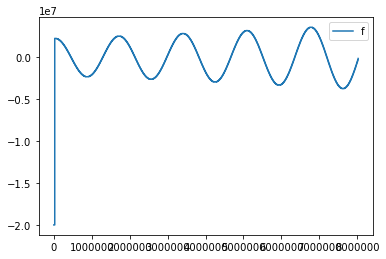

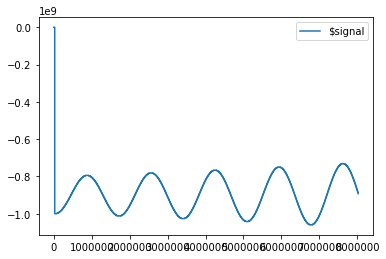

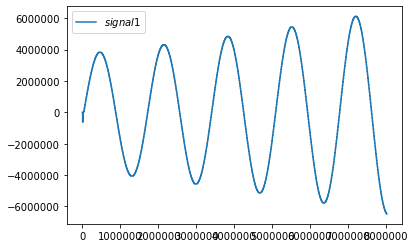

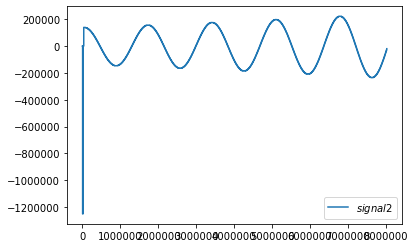

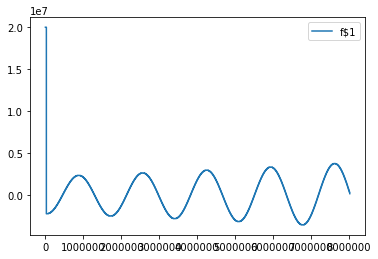

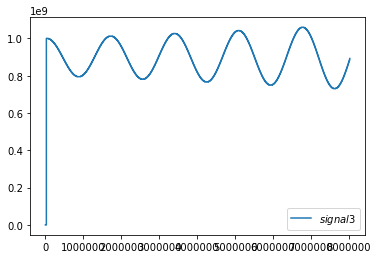

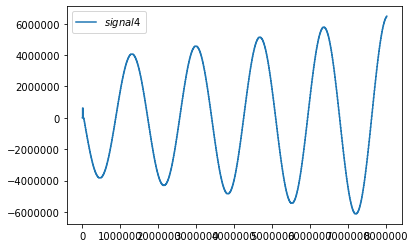

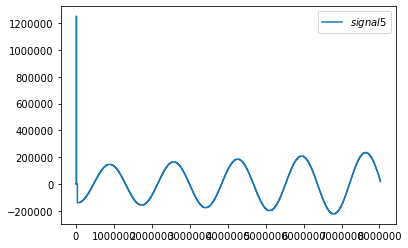

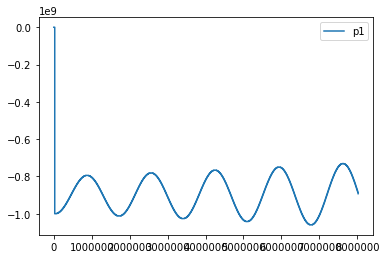

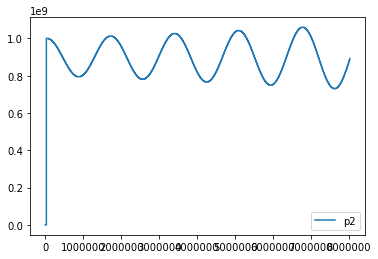

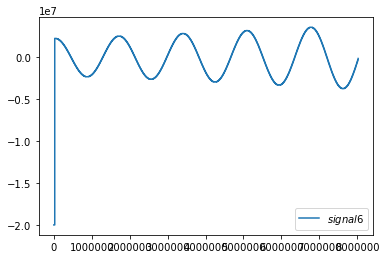

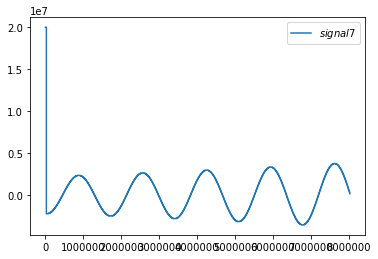

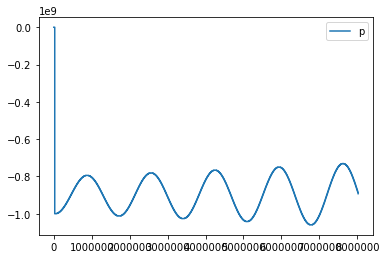

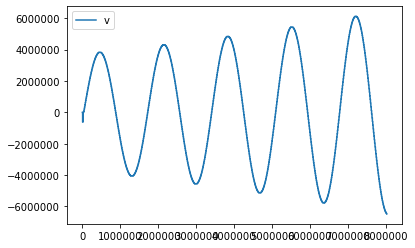

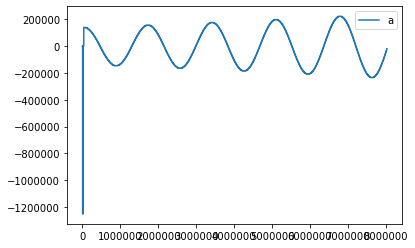

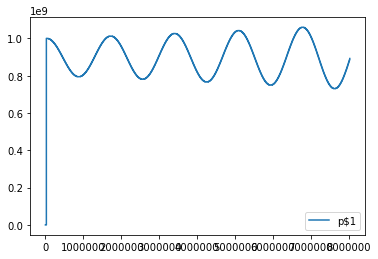

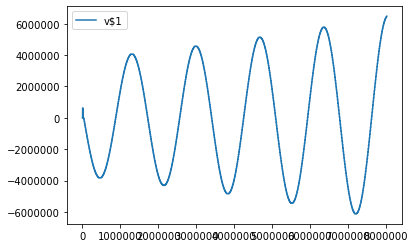

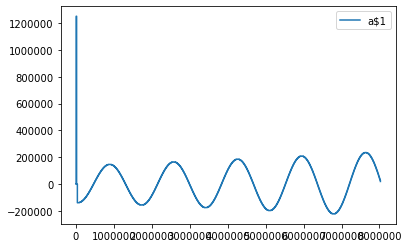

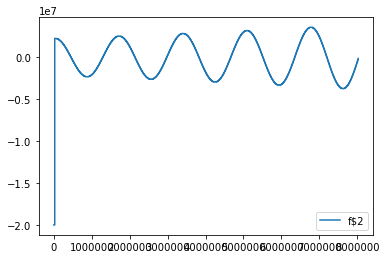

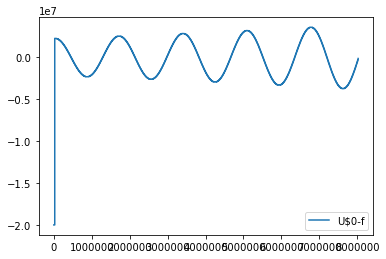

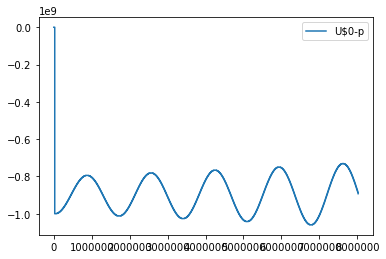

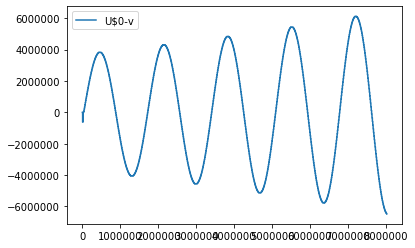

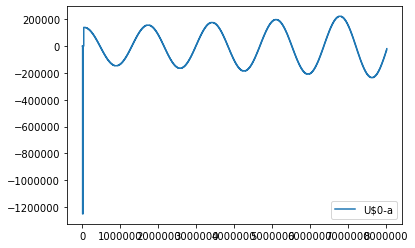

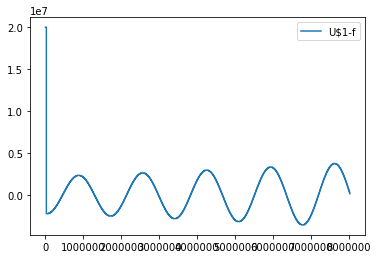

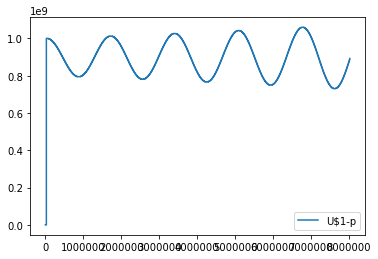

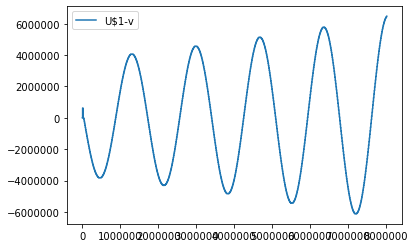

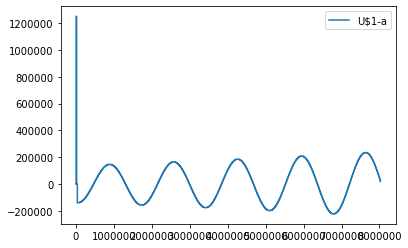

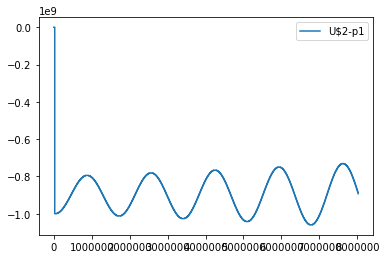

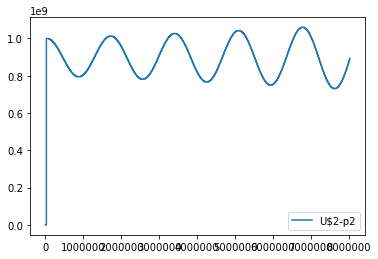

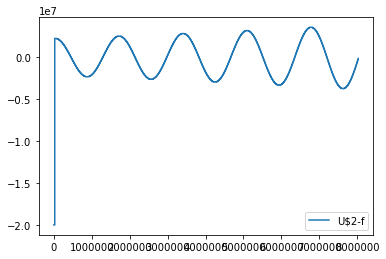

In [4]:
for t in traces.keys():
    if len(set(traces[t]['value'])) > 2:
        plot_traces(traces, t)

with open('vcd.txt', 'w') as f:
    f.write(''.join(lines))